## Churn Prediction 
### A Machine Learning Model That Can Predict Customers Who Will Leave The Company

The aim is to predict whether a bank's customers leave the bank or not. If the Client has closed his/her bank account, he/she has left.

## Dataset

- **RowNumber:** corresponds to the record (row) number and has no effect on the output.
- **CustomerId:** contains random values and has no effect on customer leaving the bank.
- **Surname:** the surname of a customer has no impact on their decision to leave the bank.
- **CreditScore:** can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- **Geography:** a customer’s location can affect their decision to leave the bank.
- **Gender:** it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age:** this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure:** refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
- **Balance:** also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- **NumOfProducts:** refers to the number of products that a customer has purchased through the bank.
- **HasCrCard:** denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- **IsActiveMember:** active customers are less likely to leave the bank.
- **EstimatedSalary:** as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited:** whether or not the customer left the bank.  (0=No,1=Yes)



### The model created as a result of LightGBM hyperparameter optimization (0.867300)

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [2]:
# reading the data
df = pd.read_csv("churn.csv", index_col=0)

# 1- EDA

In [3]:
# The first 5 observation 
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# The size of the data set 
df.shape

(10000, 13)

In [5]:
# Feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# Descriptive statistics of the data set
df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


In [7]:
# categorical Variables
categorical_variables = [col for col in df.columns if col in "O"
                        or df[col].nunique() <=11
                        and col not in "Exited"]

categorical_variables

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [8]:
# Numeric Variables
numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >11
                        and col not in "CustomerId"]
numeric_variables

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

## Exited (Dependent Variable)

In [9]:
# Frequency of classes of dependent variable
df["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [10]:
# Customers leaving the bank
churn = df.loc[df["Exited"]==1]

In [11]:
# Customers who did not leave the bank
not_churn = df.loc[df["Exited"]==0]

# Categorical Variables

## Tenure

In [12]:
# Frequency of not_churn group according to Tenure
not_churn["Tenure"].value_counts().sort_values()

Tenure
0     318
10    389
6     771
9     771
4     786
3     796
1     803
5     803
8     828
2     847
7     851
Name: count, dtype: int64

In [13]:
# Frequency of churn group according to Tenure
churn["Tenure"].value_counts().sort_values()

Tenure
0      95
10    101
7     177
6     196
8     197
2     201
4     203
5     209
3     213
9     213
1     232
Name: count, dtype: int64

## NumOfProducts

In [14]:
# Frequency of not_churn group according to NumOfProducts
not_churn["NumOfProducts"].value_counts().sort_values()

NumOfProducts
3      46
1    3675
2    4242
Name: count, dtype: int64

In [15]:
# Frequency of churn group according to NumOfProducts
churn["NumOfProducts"].value_counts().sort_values()

NumOfProducts
4      60
3     220
2     348
1    1409
Name: count, dtype: int64

## HasCrCard

In [16]:
# examining the HasCrCard of the not_churn group
not_churn["HasCrCard"].value_counts()

HasCrCard
1    5631
0    2332
Name: count, dtype: int64

In [17]:
# examining the HasCrCard of the churn group
churn["HasCrCard"].value_counts()

HasCrCard
1    1424
0     613
Name: count, dtype: int64

## IsActiveMember

In [18]:
# examining the IsActiveMember of the not_churn group
not_churn["IsActiveMember"].value_counts()

IsActiveMember
1    4416
0    3547
Name: count, dtype: int64

In [19]:
# examining the IsActiveMember of the churn group
churn["IsActiveMember"].value_counts()

IsActiveMember
0    1302
1     735
Name: count, dtype: int64

## Geography

In [20]:
# Frequency of not_churn group according to Geography
not_churn.Geography.value_counts().sort_values()

Geography
Germany    1695
Spain      2064
France     4204
Name: count, dtype: int64

In [21]:
# Frequency of churn group according to Geography
churn.Geography.value_counts().sort_values()

Geography
Spain      413
France     810
Germany    814
Name: count, dtype: int64

## Gender

In [22]:
# Frequency of not_churn group according to Gender
not_churn.Gender.value_counts()

Gender
Male      4559
Female    3404
Name: count, dtype: int64

In [23]:
# Frequency of churn group according to Gender
churn.Gender.value_counts()

Gender
Female    1139
Male       898
Name: count, dtype: int64

# Numerical Variables

## CreditScore

In [24]:
# Let's examine the credit score of the not_churn group
not_churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
5%        492.000000
25%       585.000000
50%       653.000000
75%       718.000000
90%       778.000000
95%       812.000000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

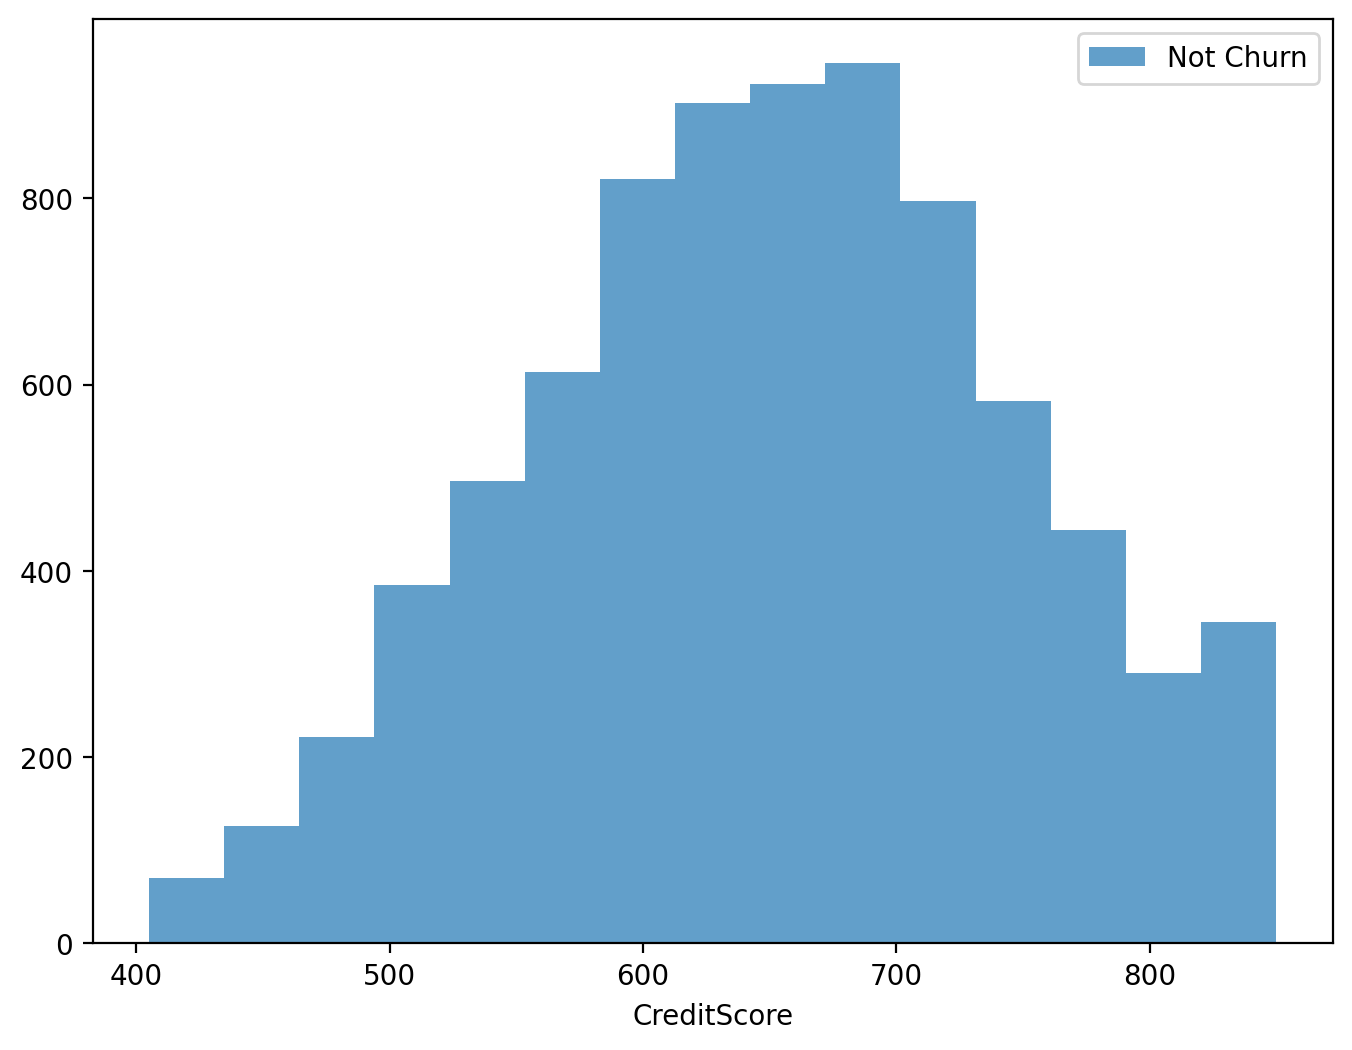

In [25]:
# distribution of the Credit Score for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(not_churn["CreditScore"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [26]:
# Let's examine the credit score of the churn group
churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
5%        479.000000
25%       578.000000
50%       646.000000
75%       716.000000
90%       776.400000
95%       812.200000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

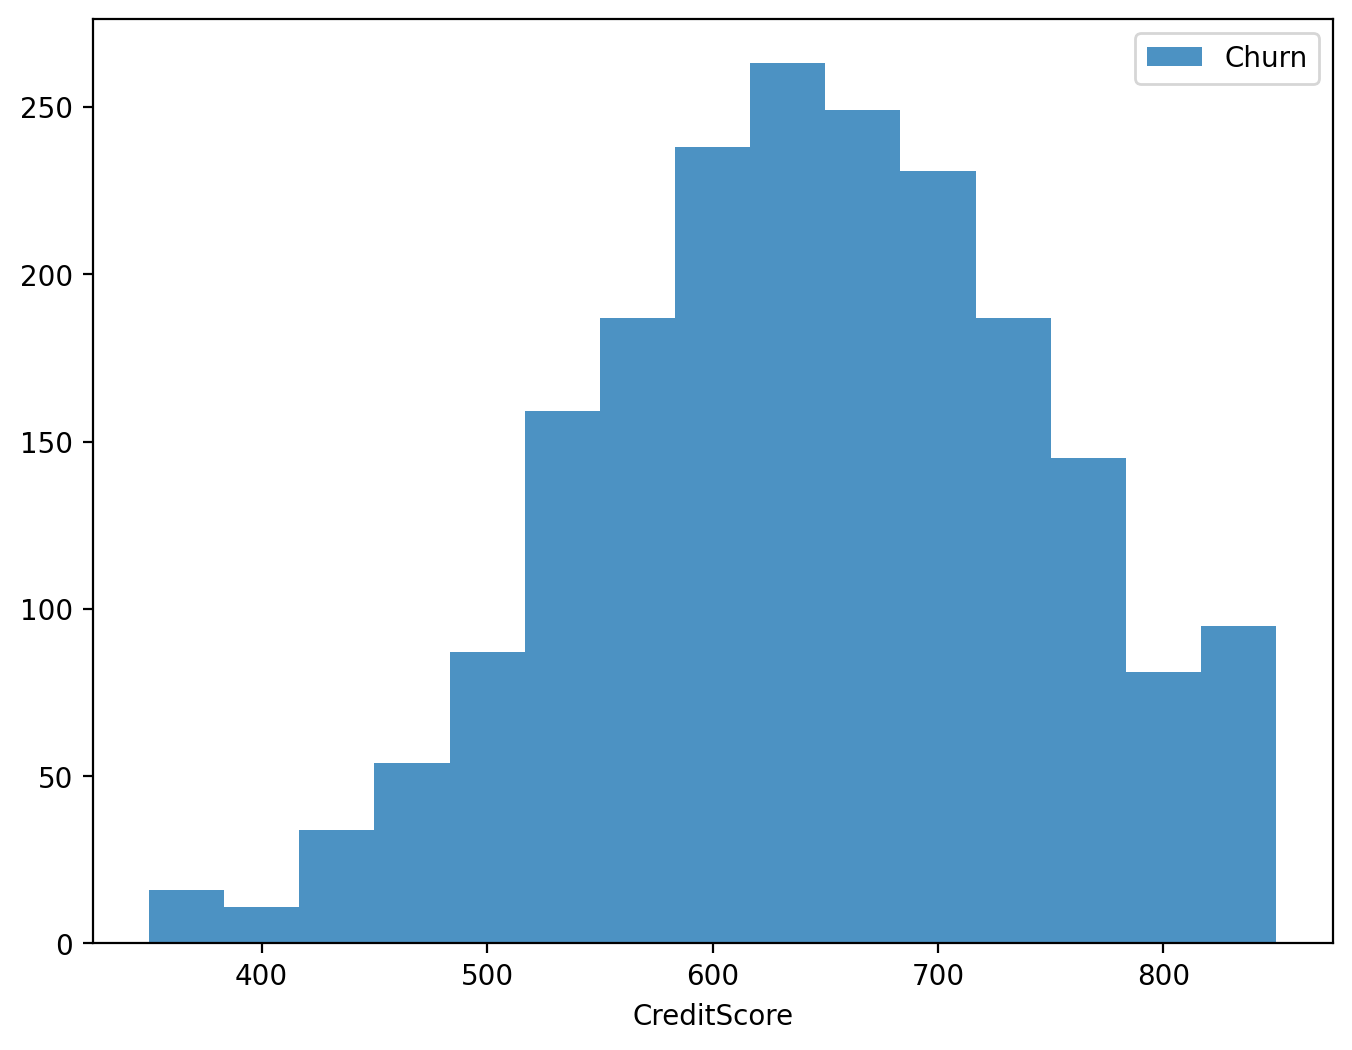

In [27]:
# distribution of the Credit Score for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('CreditScore')
pyplot.hist(churn["CreditScore"],bins=15, alpha=0.8, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

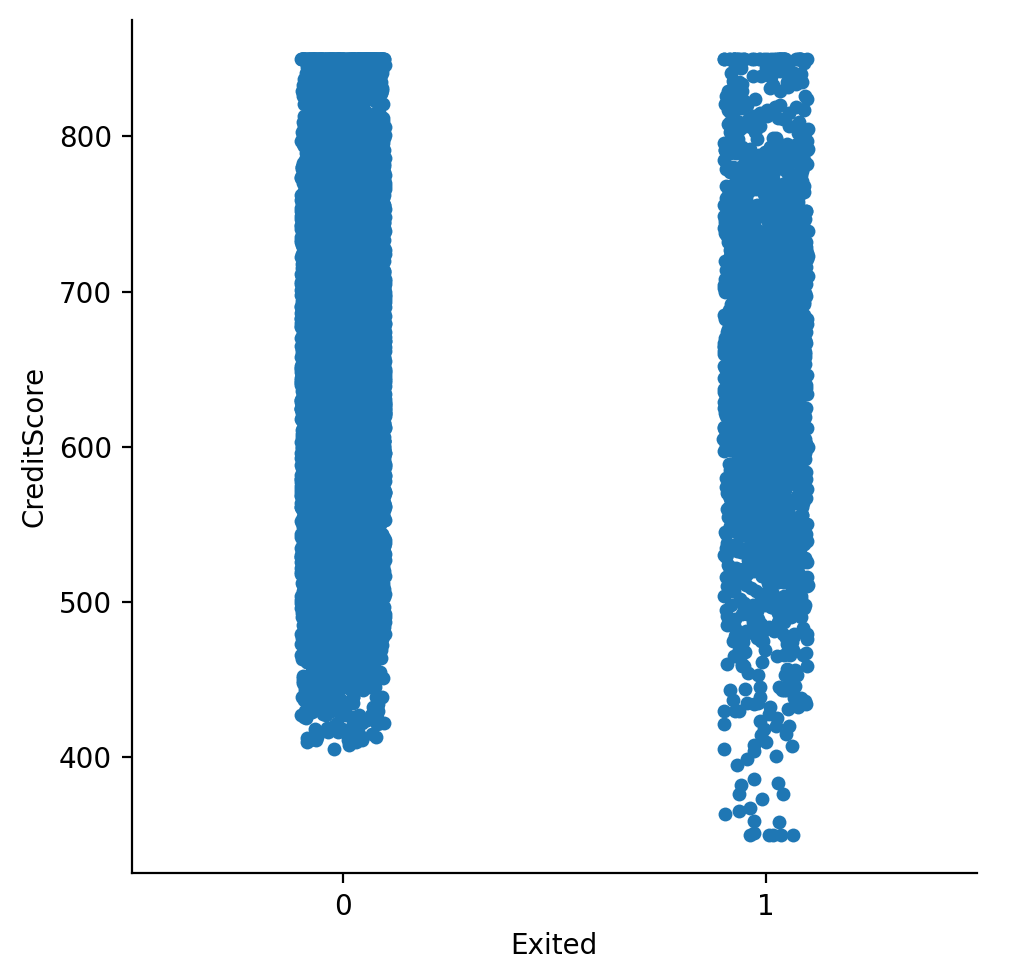

In [28]:
sns.catplot(x="Exited", y="CreditScore", data=df)


## Age

In [29]:
# examining the age of the not_churn group
not_churn["Age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    7963.000000
mean       37.408389
std        10.125363
min        18.000000
5%         24.000000
25%        31.000000
50%        36.000000
75%        41.000000
90%        49.000000
95%        59.000000
99%        73.000000
max        92.000000
Name: Age, dtype: float64

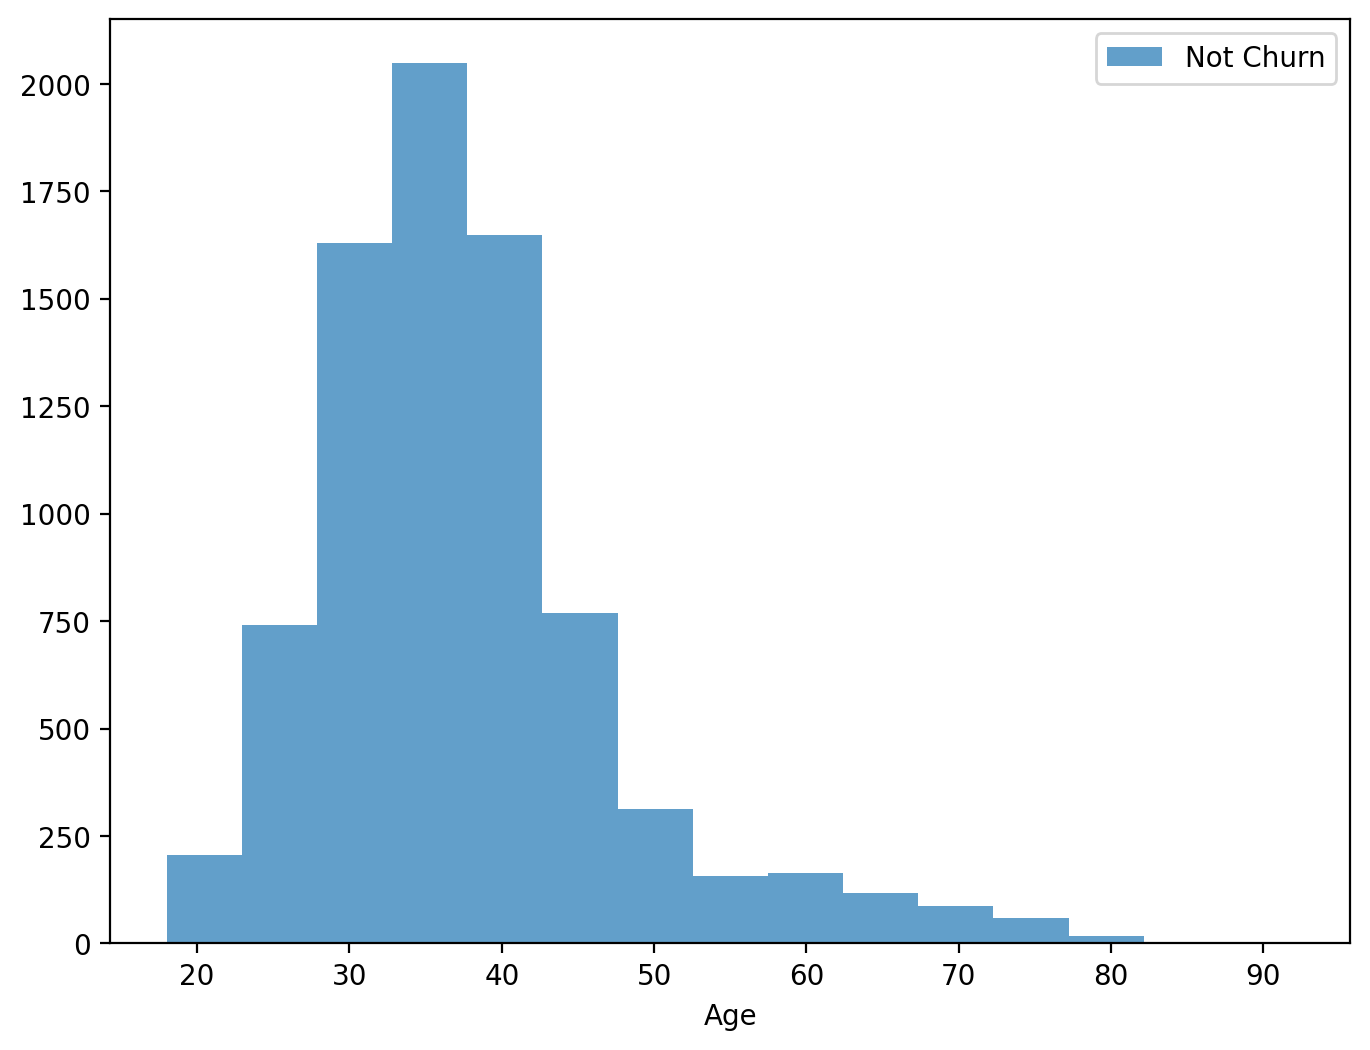

In [30]:
# distribution of the Age for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(not_churn["Age"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [31]:
# examine the age of the churn group
churn["Age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    2037.000000
mean       44.837997
std         9.761562
min        18.000000
5%         29.000000
25%        38.000000
50%        45.000000
75%        51.000000
90%        58.000000
95%        61.000000
99%        68.000000
max        84.000000
Name: Age, dtype: float64

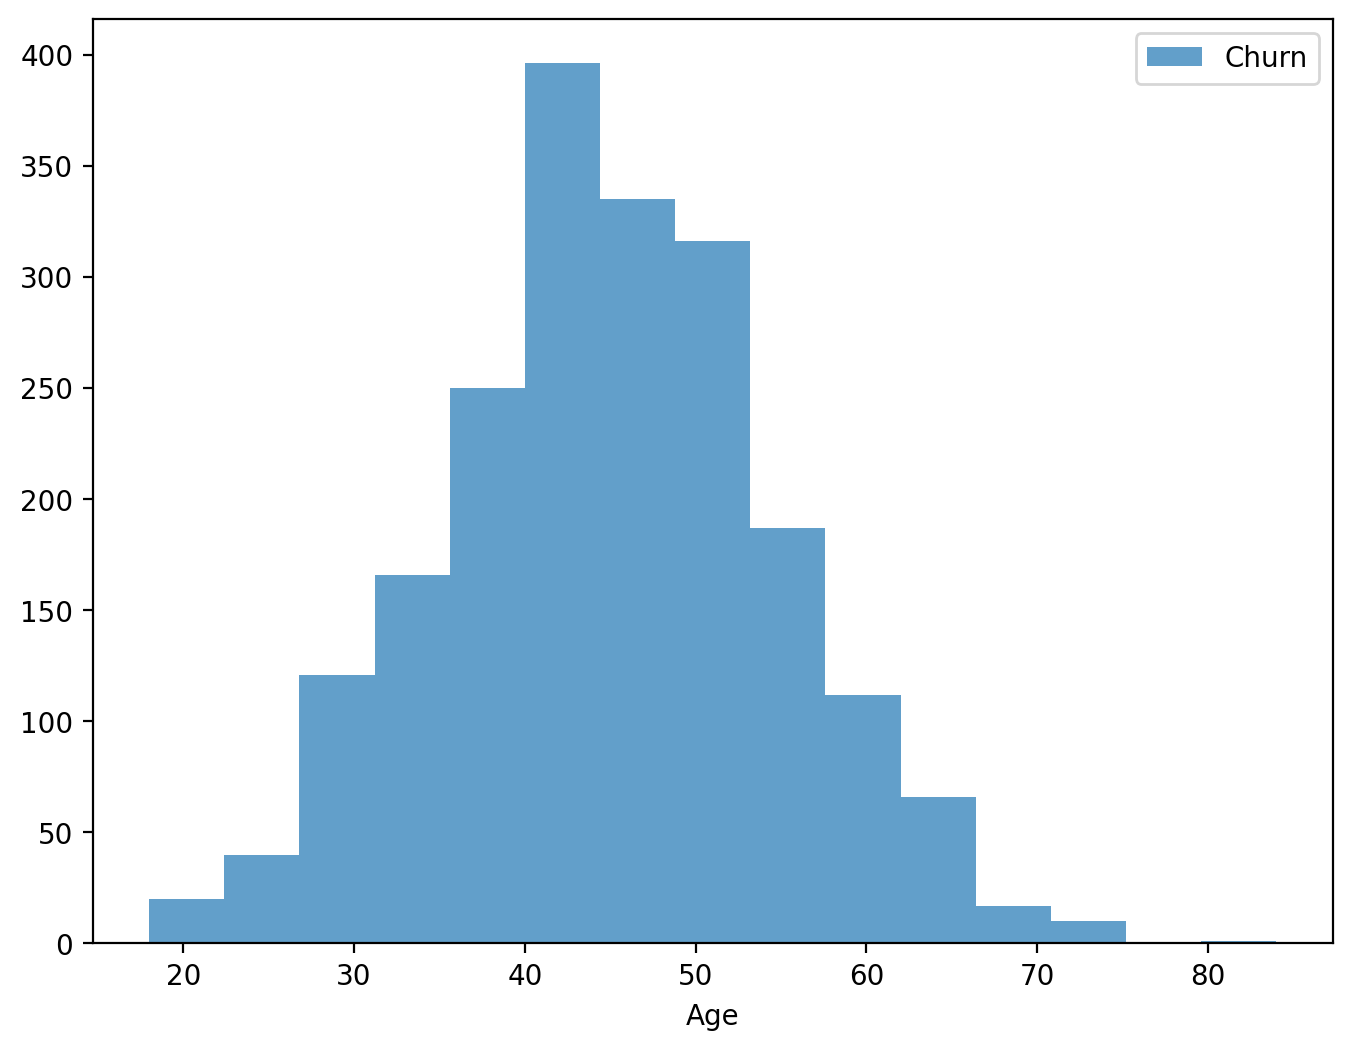

In [32]:
# distribution of the Age for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(churn["Age"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

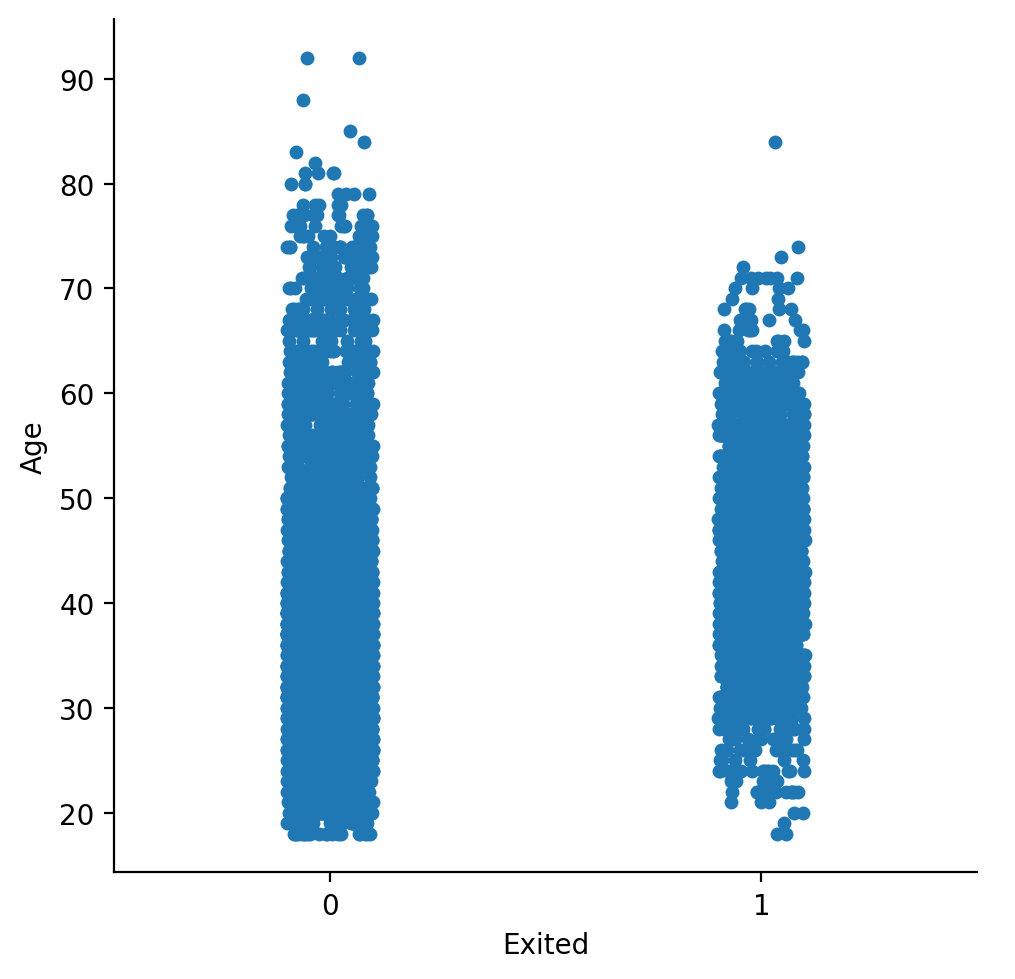

In [33]:
sns.catplot(x="Exited",y= "Age", data = df)

## Balance

In [34]:
# examining the Balance of the not_churn group
not_churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      7963.000000
mean      72745.296779
std       62848.040701
min           0.000000
5%            0.000000
25%           0.000000
50%       92072.680000
75%      126410.280000
90%      148730.298000
95%      161592.595000
99%      183753.906200
max      221532.800000
Name: Balance, dtype: float64

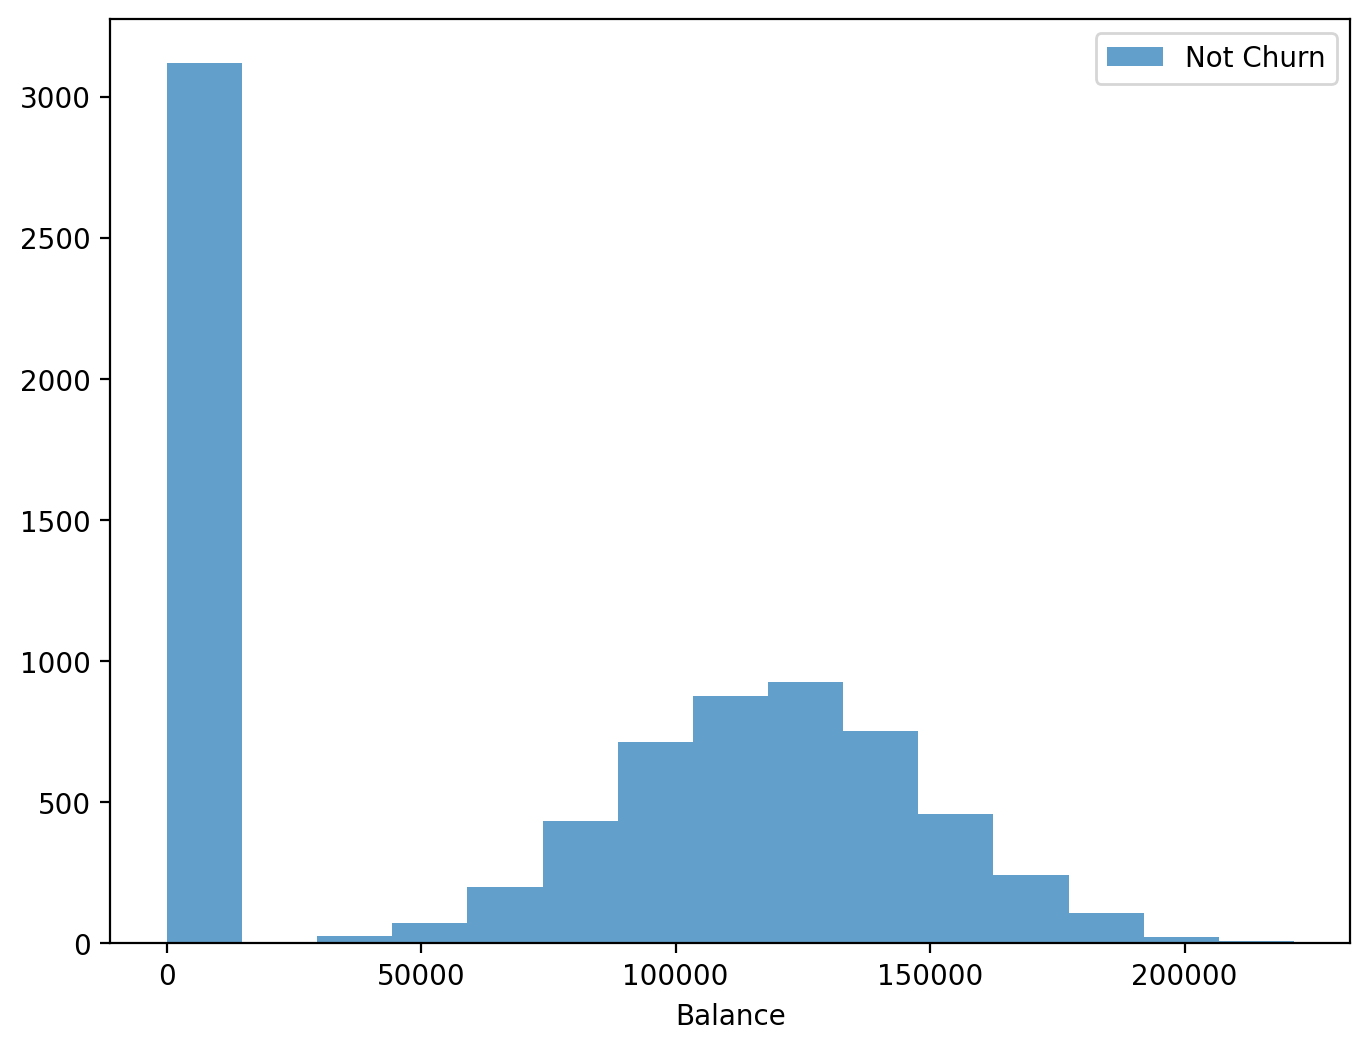

In [35]:
# distribution of the Balance for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(not_churn["Balance"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [36]:
# examining the Balance of the churn group
churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      2037.000000
mean      91108.539337
std       58360.794816
min           0.000000
5%            0.000000
25%       38340.020000
50%      109349.290000
75%      131433.330000
90%      152080.618000
95%      167698.240000
99%      197355.288400
max      250898.090000
Name: Balance, dtype: float64

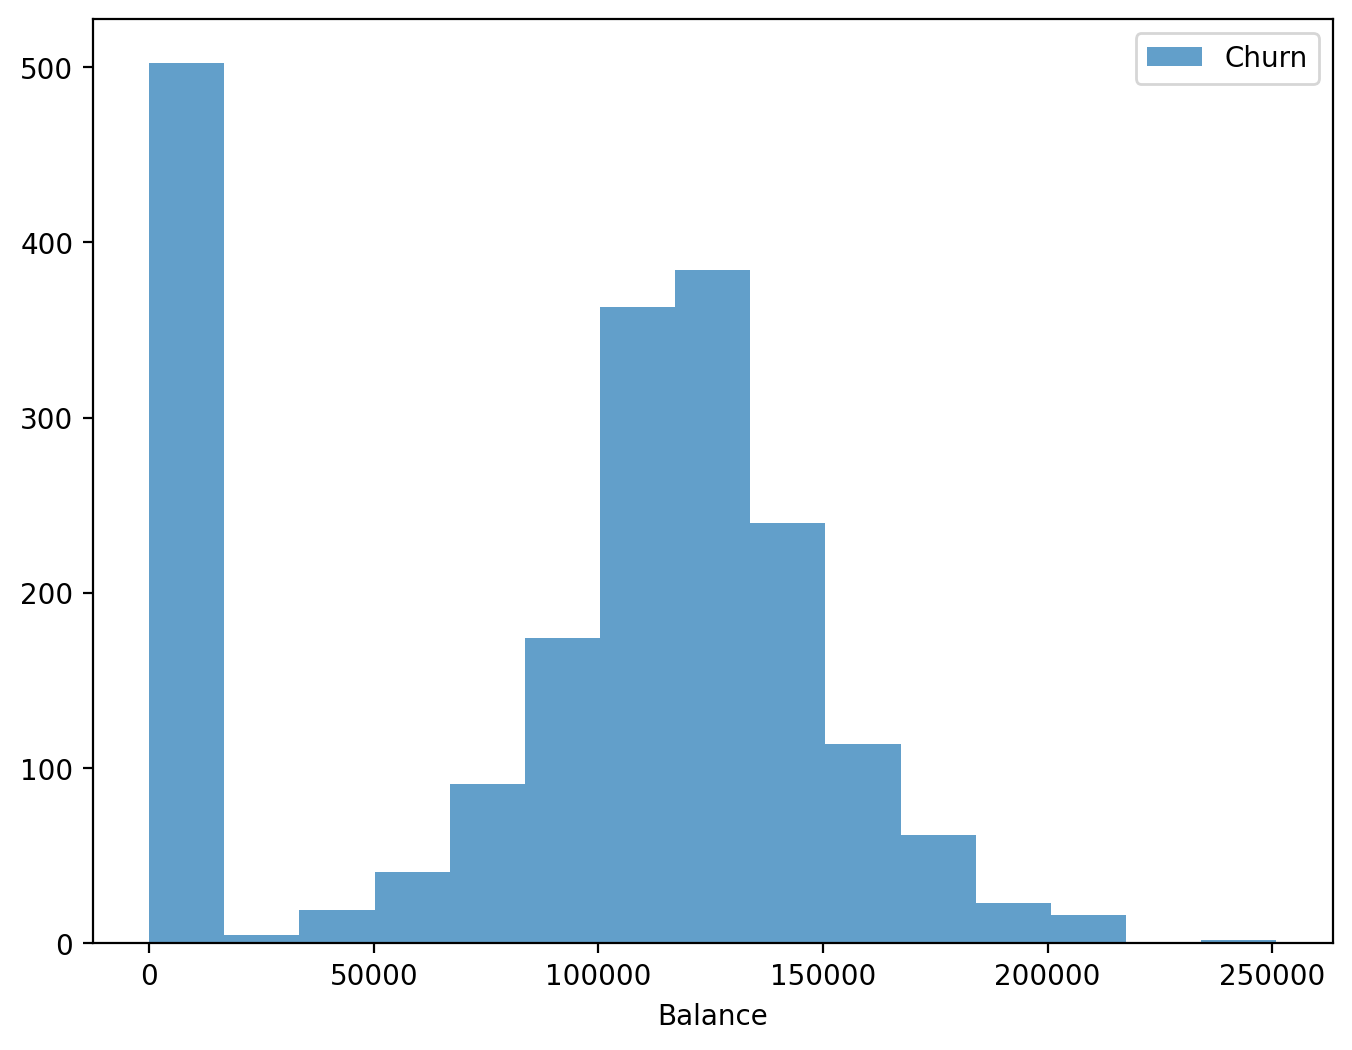

In [37]:
# distribution of the Balance for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Balance')
pyplot.hist(churn["Balance"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

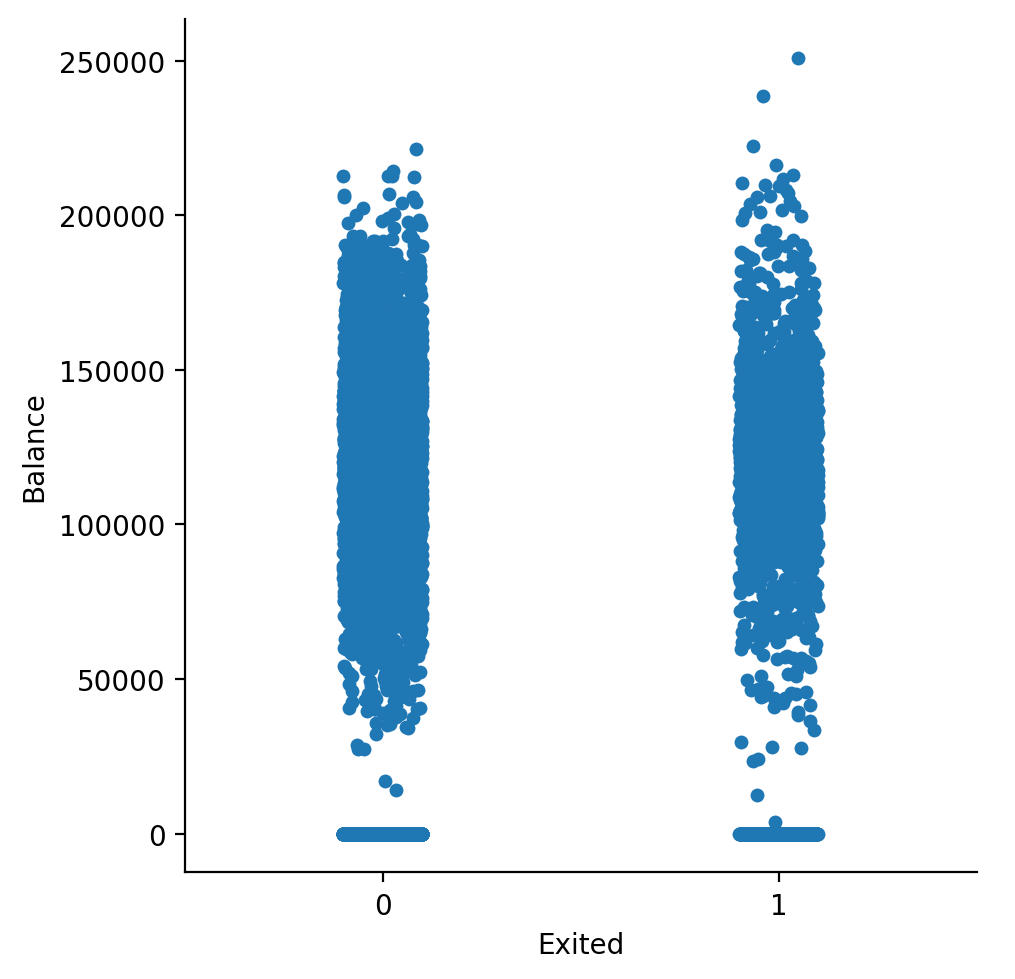

In [38]:
sns.catplot(x="Exited",y= "Balance", data = df)

## EstimatedSalary

In [39]:
# examining the EstimatedSalary of the not_churn group
not_churn["EstimatedSalary"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      7963.000000
mean      99738.391772
std       57405.586966
min          90.070000
5%         9773.542000
25%       50783.490000
50%       99645.040000
75%      148609.955000
90%      179453.212000
95%      190107.557000
99%      198131.465200
max      199992.480000
Name: EstimatedSalary, dtype: float64

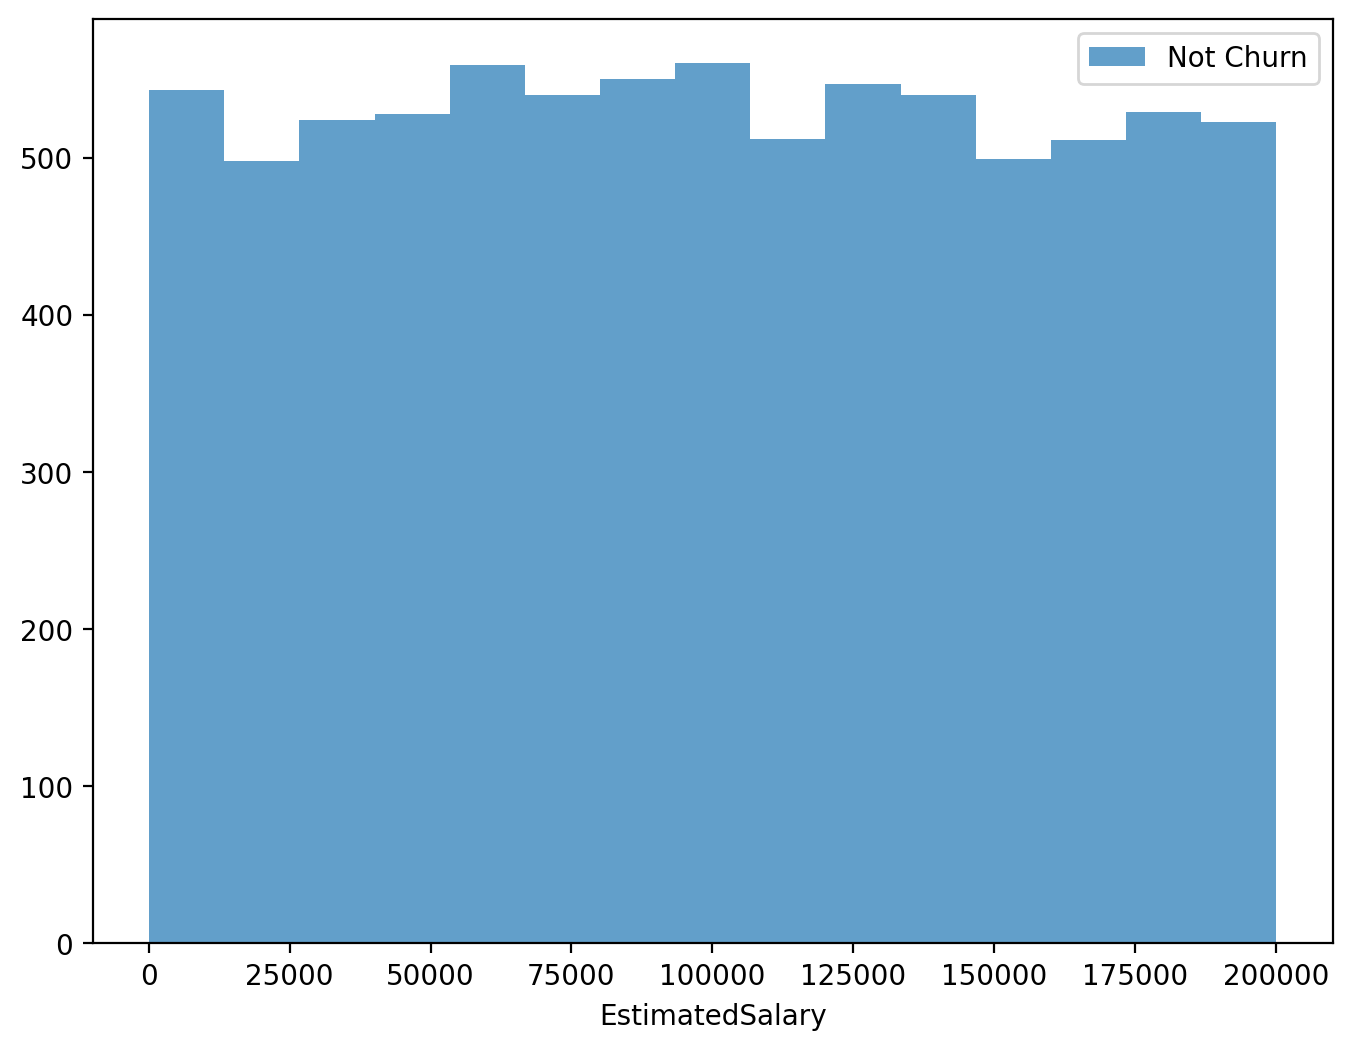

In [40]:
# distribution of the Balance for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('EstimatedSalary')
pyplot.hist(not_churn["EstimatedSalary"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [41]:
# examining the EstimatedSalary of the churn group
churn["EstimatedSalary"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      2037.000000
mean     101465.677531
std       57912.418071
min          11.580000
5%        10030.760000
25%       51907.720000
50%      102460.840000
75%      152422.910000
90%      180169.390000
95%      190328.982000
99%      197717.297600
max      199808.100000
Name: EstimatedSalary, dtype: float64

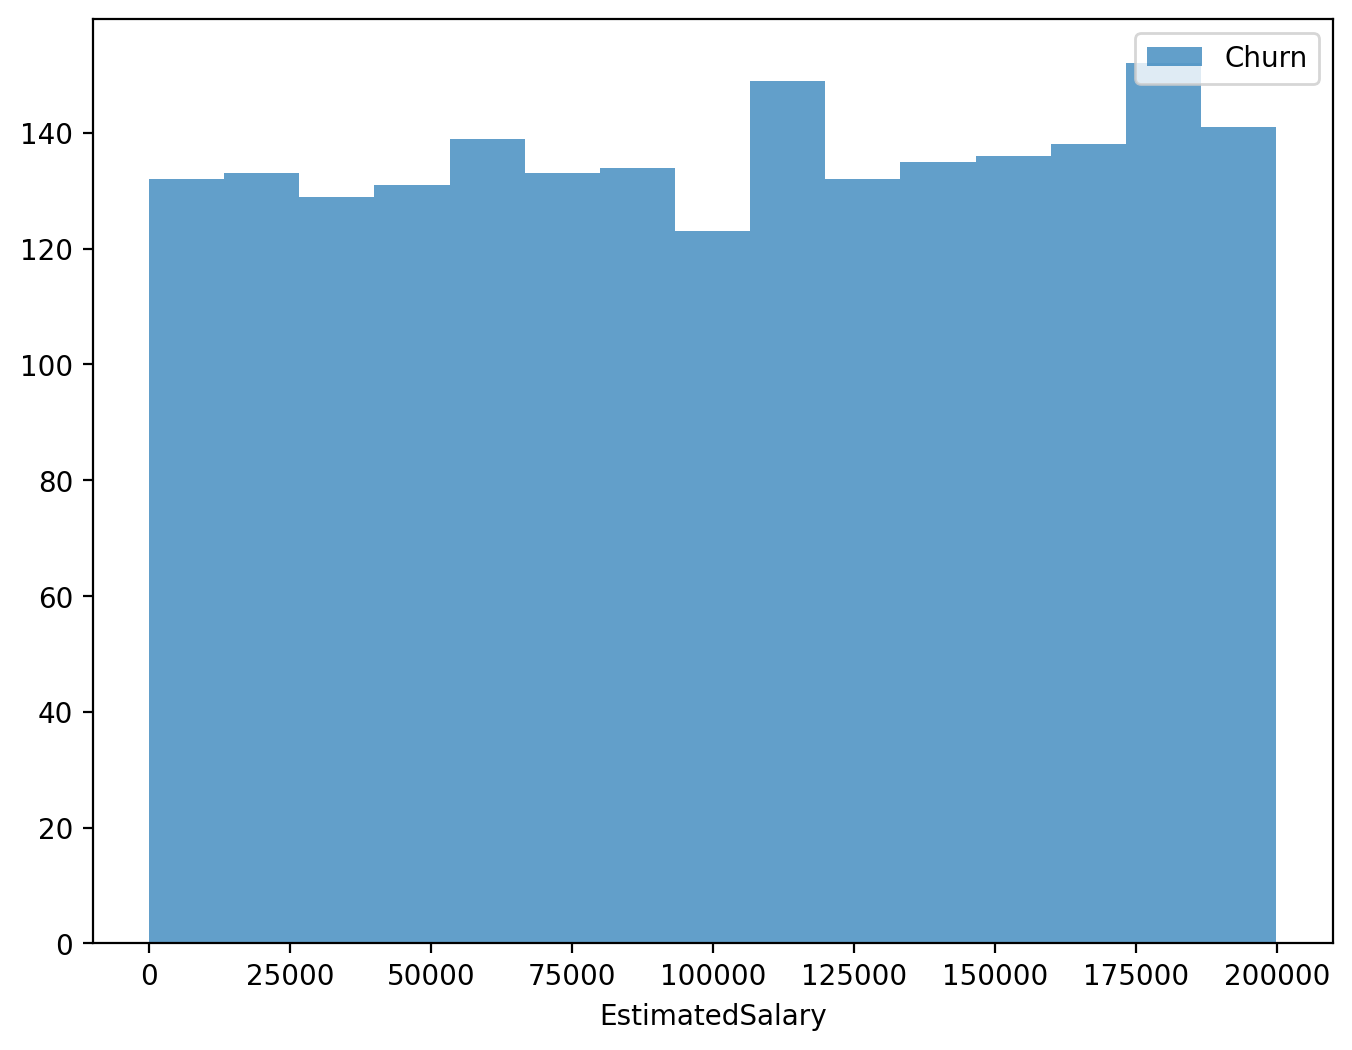

In [42]:
# distribution of the EstimatedSalary for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('EstimatedSalary')
pyplot.hist(churn["EstimatedSalary"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

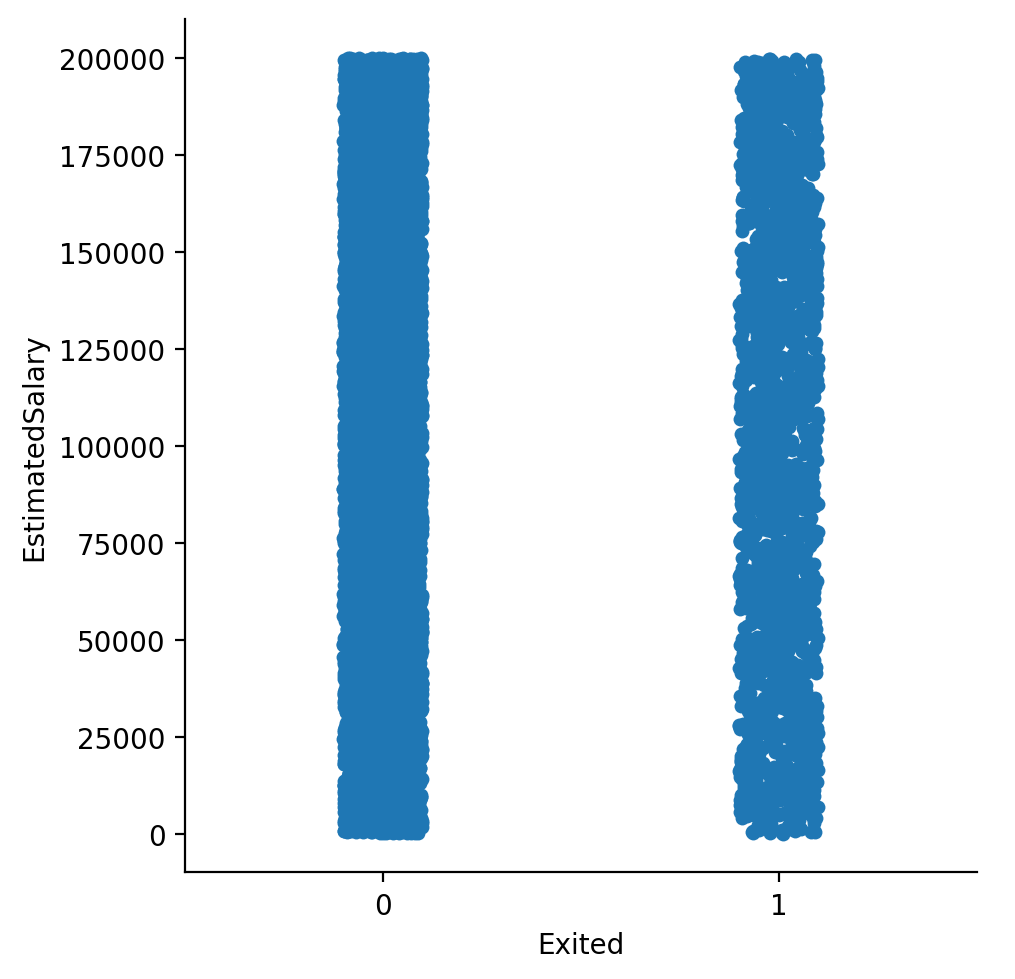

In [43]:
sns.catplot(x="Exited",y= "EstimatedSalary", data = df)

# Correlation Matrix

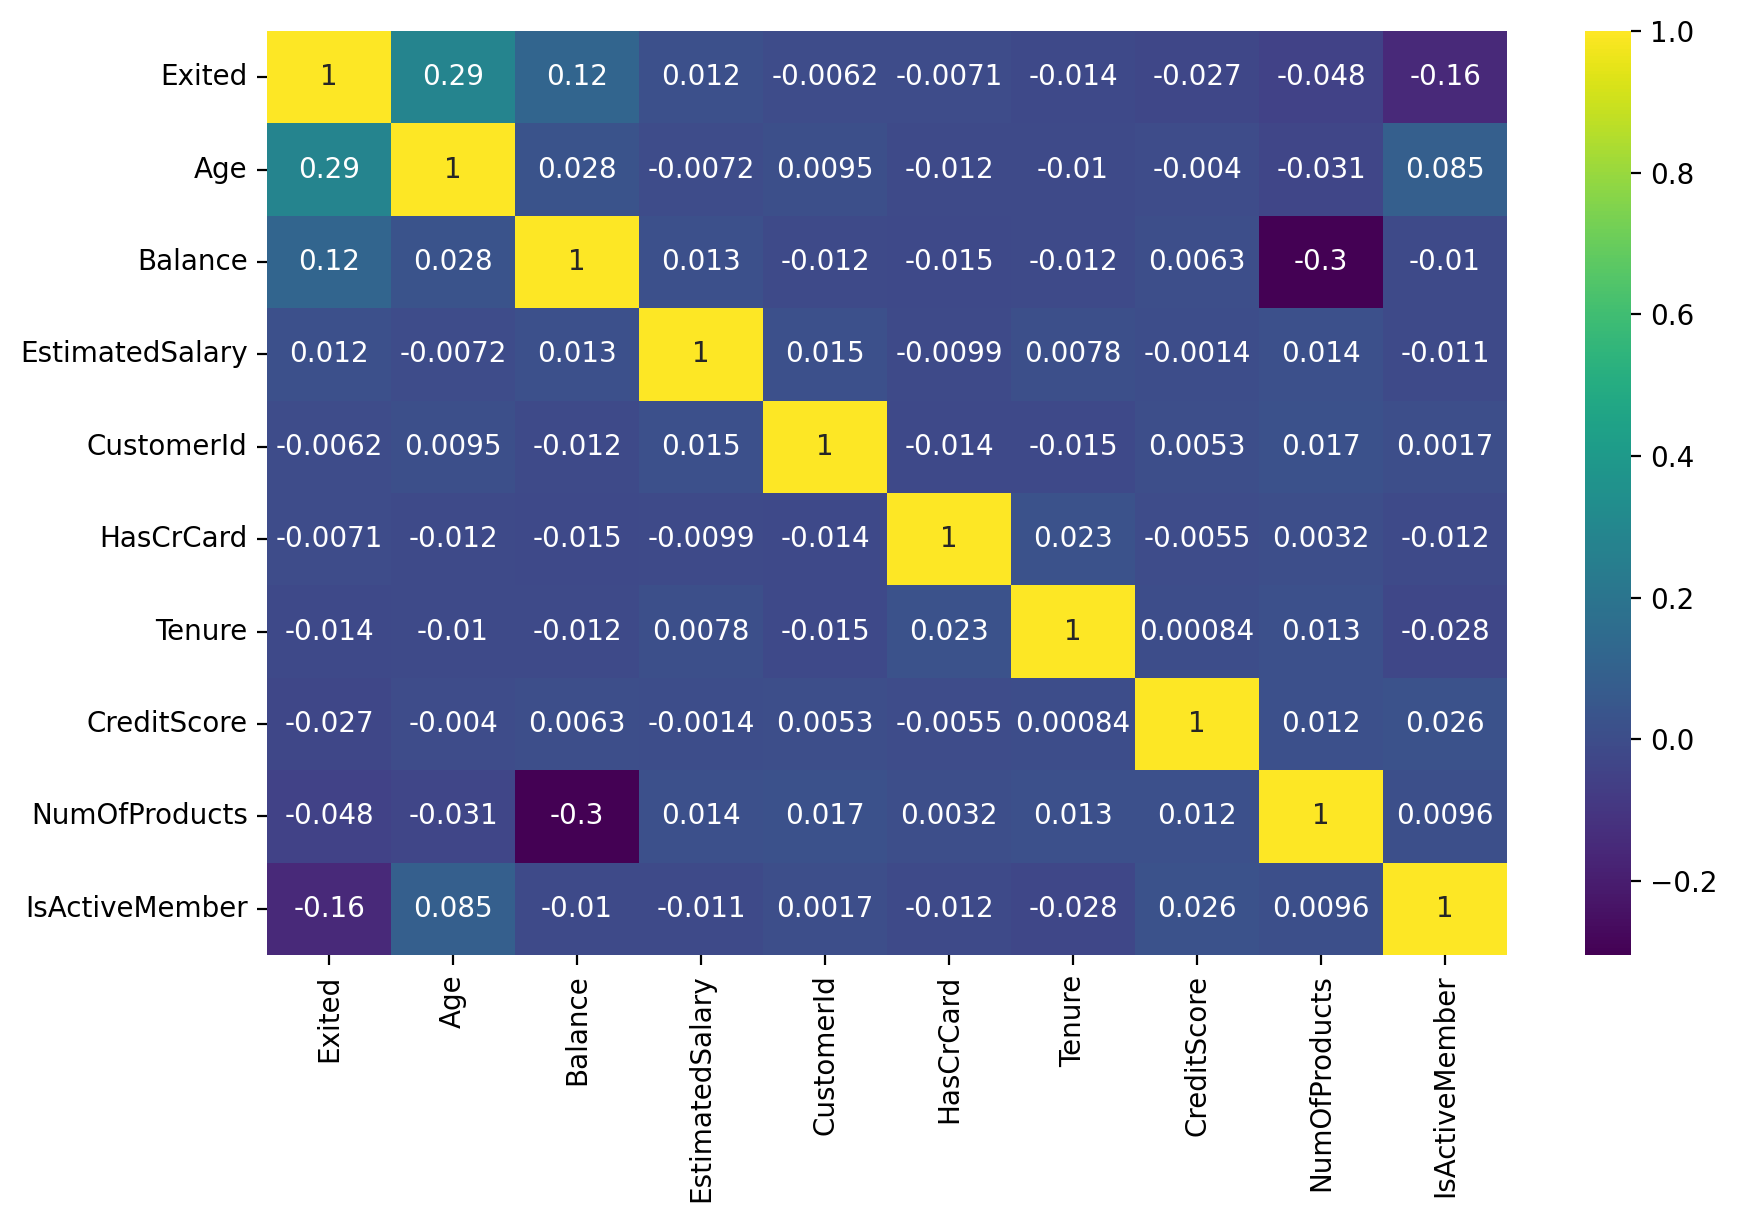

In [44]:
numeric_df = df.select_dtypes(include=[np.number])
k = 10  # Number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'Exited')['Exited'].index
cm = numeric_df[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()


# 2- Data Preprocessing

## Missing Value

In [45]:
# # Missing Observation Analysis
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Outliers

In [46]:
# To determine the threshold value for outliers
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [47]:
# Are there any outliers in the variables
def has_outliers(dataframe, numeric_columns, plot=False):
   # variable_names = []
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, " : ", number_of_outliers, "outliers")
            #variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    #return variable_names

In [48]:
# There is no outlier
for var in numeric_variables:
    print(var, "has " , has_outliers(df, [var]),  "Outliers")

CreditScore has  None Outliers
Age has  None Outliers
Balance has  None Outliers
EstimatedSalary has  None Outliers


## Feature Engineering

In [49]:
# we standardize tenure with age
df["NewTenure"] = df["Tenure"]/df["Age"]
df["NewCreditsScore"] = pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df["NewAgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["NewBalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df["NewEstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [50]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore
RowNumber,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4


## One Hot Encoding

In [51]:
# Variables to apply one hot encoding
list = ["Gender", "Geography"]
df = pd.get_dummies(df, columns =list, drop_first = True)

In [52]:
df.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6,False,False,False
2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6,False,False,True
3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6,False,False,False
4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5,False,False,False
5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4,False,False,True


# Scalling

In [53]:
# Removing variables that will not affect the dependent variable
df = df.drop(["CustomerId","Surname"], axis = 1)

In [54]:
# Scale features using statistics that are robust to outliers.
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [55]:
new_cols_ohe = ["Gender_Male","Geography_Germany","Geography_Spain"]
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) <= 10]
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Exited"
                   and col not in like_num]

for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

In [56]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,,,,
1,-0.246,0.417,-0.75,-0.761,1,1,1,0.012,1,-0.217,3,6,1,6,False,False,False
2,-0.328,0.333,-1.00,-0.105,1,0,1,0.126,0,-0.279,2,6,3,6,False,False,True
3,-1.119,0.417,0.75,0.489,3,1,0,0.140,1,0.164,1,6,5,6,False,False,False
4,0.351,0.167,-1.00,-0.761,2,0,0,-0.065,0,-0.276,5,5,1,5,False,False,False
5,1.478,0.500,-0.75,0.222,1,1,1,-0.215,0,-0.220,6,6,4,4,False,False,True


# 3- Modeling

In [57]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# Train-Test Separation
X = df.drop("Exited", axis=1)
y = df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)

# Models for Classification
models = [
    ('LR', LogisticRegression(random_state=123456)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=123456)),
    ('RF', RandomForestClassifier(random_state=123456)),
    ('SVR', SVC(gamma='auto', random_state=123456)),
    ('GB', GradientBoostingClassifier(random_state=12345)),
    ("LightGBM", LGBMClassifier(random_state=123456))
]

results = []
names = []

# Corrected KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=123456)

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.825300 (0.008855)
KNN: 0.820900 (0.009648)
CART: 0.790600 (0.011047)
RF: 0.861900 (0.008324)
SVR: 0.845200 (0.008195)
GB: 0.865000 (0.008426)
[LightGBM] [Info] Number of positive: 1832, number of negative: 7168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203556 -> initscore=-1.364218
[LightGBM] [Info] Start training from score -1.364218
[LightGBM] [Info] Number of positive: 1827, number of negative: 7173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

In [58]:
# GB Confusion Matrix
model_GB = GradientBoostingClassifier(random_state=12345)
model_GB.fit(X_train, y_train)
y_pred = model_GB.predict(X_test)
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[1520,  230],
       [  53,  197]], dtype=int64)

In [59]:
print("True Positive : ", conf_mat[1, 1])
print("True Negative : ", conf_mat[0, 0])
print("False Positive: ", conf_mat[0, 1])
print("False Negative: ", conf_mat[1, 0])

True Positive :  197
True Negative :  1520
False Positive:  230
False Negative:  53


In [60]:
# Classification Report for XGB Model
print(classification_report(model_GB.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1750
           1       0.46      0.79      0.58       250

    accuracy                           0.86      2000
   macro avg       0.71      0.83      0.75      2000
weighted avg       0.90      0.86      0.87      2000



In [61]:
# Auc Roc Curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

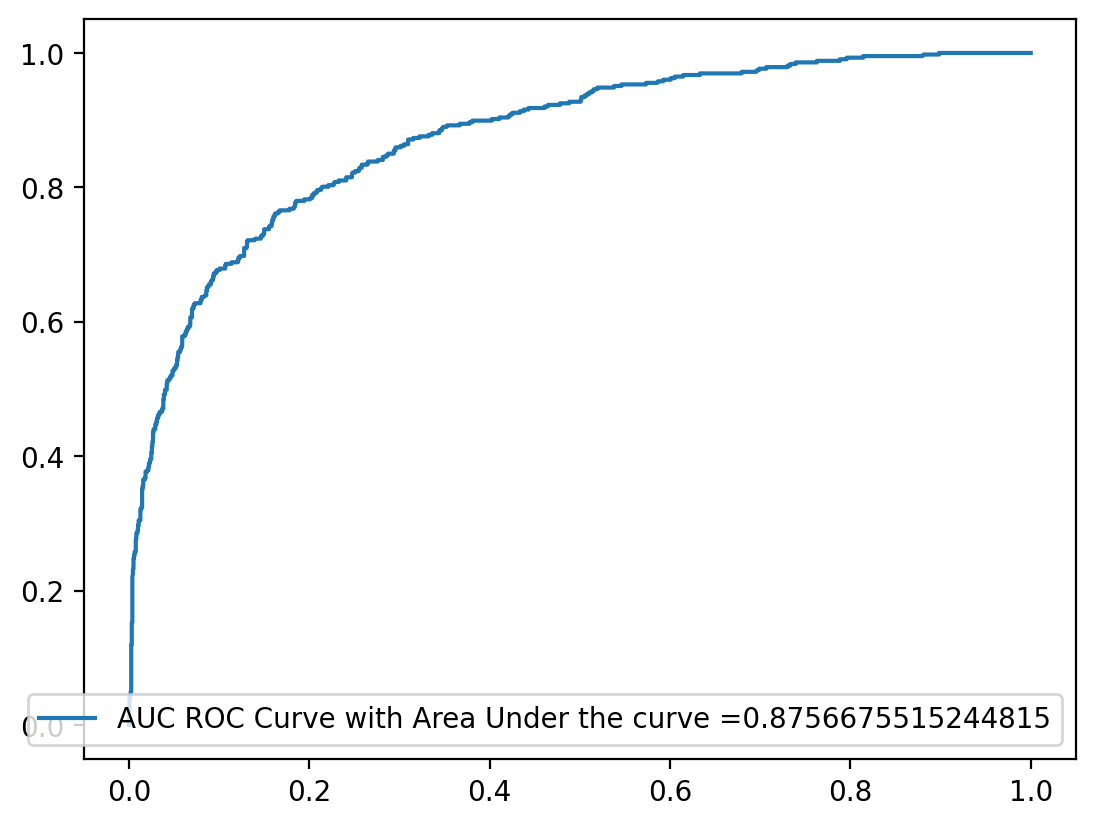

In [62]:
generate_auc_roc_curve(model_GB, X_test)

# 4- Model Tuning

In [63]:
# LightGBM: 
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500}

lgbm_tuned = LGBMClassifier(**lgbm_params).fit(X, y)

[LightGBM] [Info] Number of positive: 2037, number of negative: 7963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203700 -> initscore=-1.363328
[LightGBM] [Info] Start training from score -1.363328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [64]:
#Let's choose the highest 4 models
# GBM
gbm_model = GradientBoostingClassifier()
# Model Tuning
gbm_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
gbm_tuned = GradientBoostingClassifier(**gbm_params).fit(X,y)

In [66]:
# evaluate each model in turn
models = [("LightGBM", lgbm_tuned),
          ("GB",gbm_tuned)]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=123456)
    cv_results = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

[LightGBM] [Info] Number of positive: 1833, number of negative: 7167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203667 -> initscore=-1.363533
[LightGBM] [Info] Start training from score -1.363533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Info] Number of positive: 1610, number of negative: 6390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201250 -> initscore=-1.378500
[LightGBM] [Info] Start training from score -1.378500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

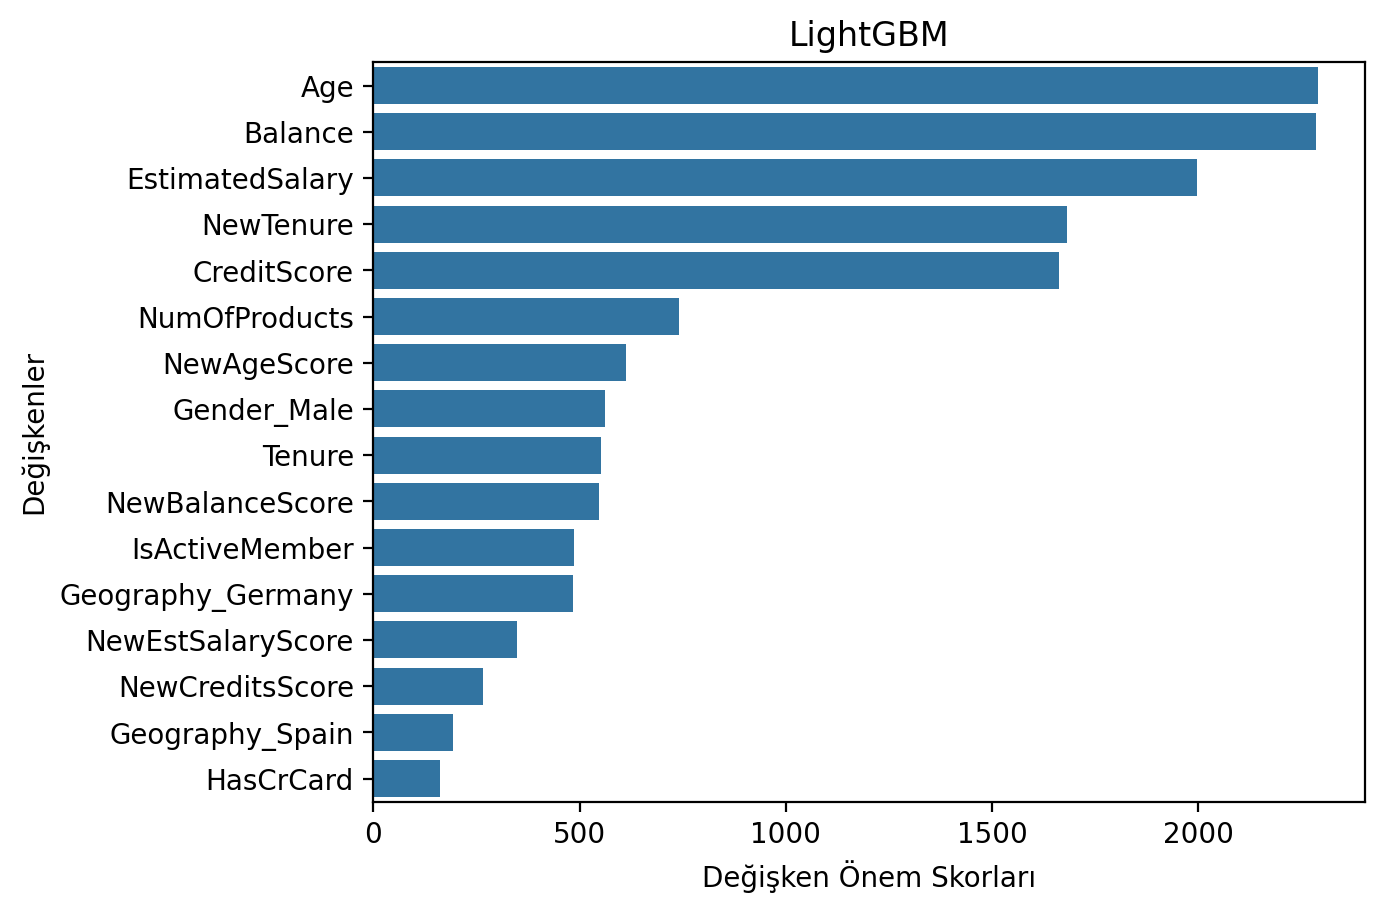

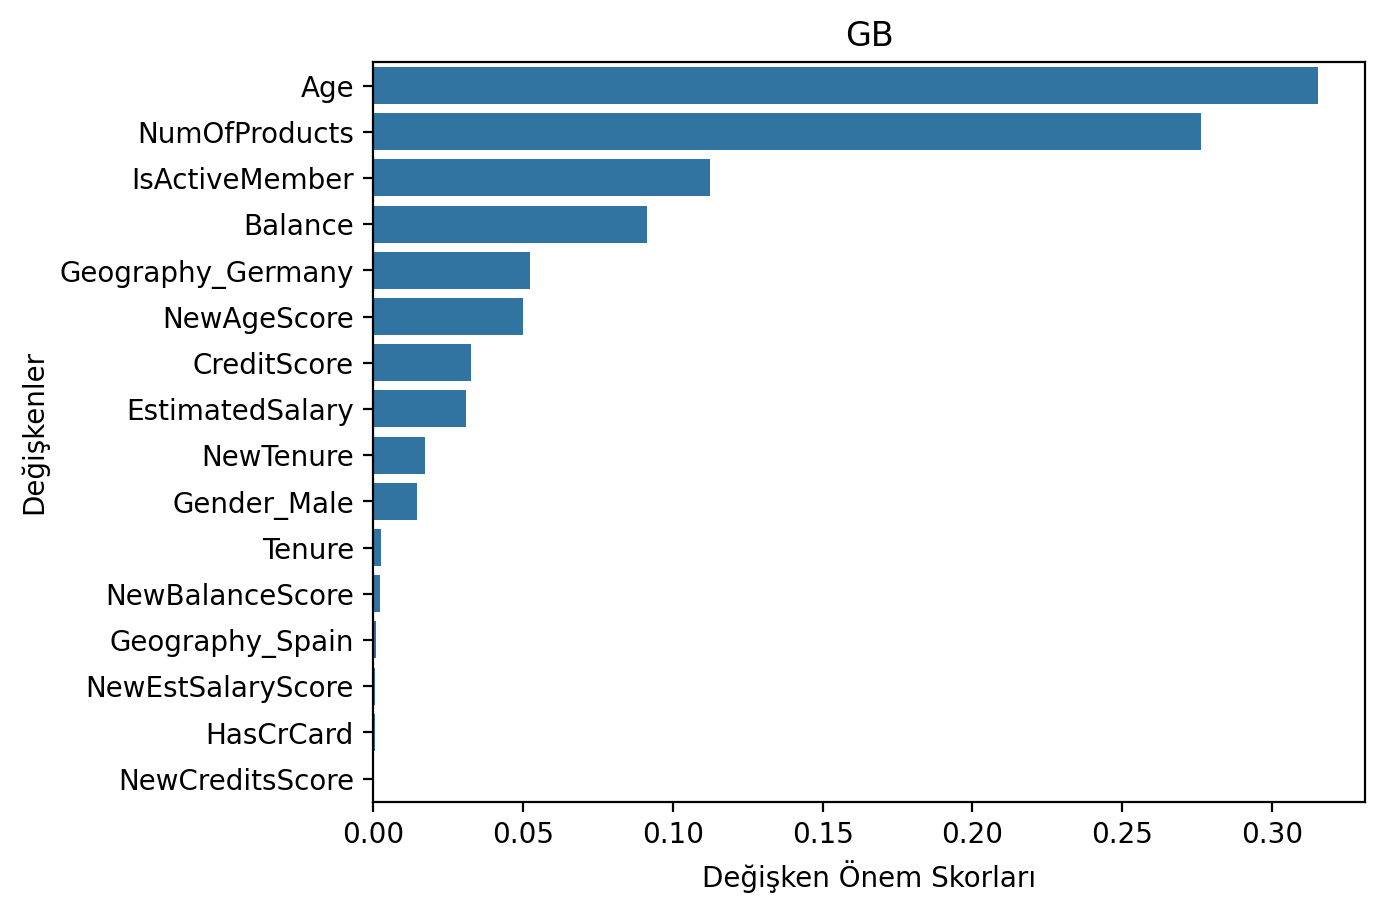

In [67]:
for name, model in models:
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Değişken Önem Skorları')
        plt.ylabel('Değişkenler')
        plt.title(name)
        plt.show()

Report

1) Churn Data Set read.

2) With Exploratory Data Analysis

4) During Model Buildingost

5) The model created as a result of LightGBM hyperparameter optimization (AUC 0.87)